In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read the results from the csv file
monitor_paths = {
    # 'random_agent': [],
    'default_agent': ['zresults/tucson_default_monitor.csv'],
    'MBRL_agent': ['zresults/tucson_NN_winter_1200_monitor.csv'],
    'CLUE': ['zresults/tucson_GPMCB_winter_7_0.3_monitor.csv'],
    'DT_agent (ours)': ['zresults/tucson_tree_monitor.csv'],
}
# for i in range(50):
#     monitor_paths['random_agent'].append('zresults/pittsburgh_random_{}_monitor.csv'.format(i))

# for i in range(10):
#     monitor_paths['MBRL_agent'].append('zresults/pittsburgh_MBRL_{}_monitor.csv'.format(i))

print(monitor_paths)

{'default_agent': ['zresults/tucson_default_monitor.csv'], 'MBRL_agent': ['zresults/tucson_NN_winter_1200_monitor.csv'], 'CLUE': ['zresults/tucson_GPMCB_winter_7_0.3_monitor.csv'], 'DT_agent (ours)': ['zresults/tucson_tree_monitor.csv']}


In [61]:
def get_violation_rate(monitor_path, comfort_lower, comfort_higher, start_timestep, end_timestep):
    monitor = pd.read_csv(monitor_path)
    violation_count = 0
    for i in range(start_timestep, end_timestep):
        if monitor['Zone People Occupant Count(SPACE1-1)'][i] > 0 and (monitor['Zone Air Temperature(SPACE1-1)'][i] < comfort_lower or monitor['Zone Air Temperature(SPACE1-1)'][i] > comfort_higher):
            violation_count += 1
    return violation_count / (end_timestep - start_timestep)

def get_total_power(monitor_path, start_timestep, end_timestep):
    monitor = pd.read_csv(monitor_path)
    total_power = 0
    for i in range(start_timestep, end_timestep):
        total_power += monitor['Facility Total HVAC Electricity Demand Rate(Whole Building)'][i]/4000
    return total_power

{'default_agent': [469.9835073727395], 'MBRL_agent': [392.6427038388927], 'CLUE': [437.51968575994016], 'DT_agent (ours)': [398.13690533317646]}


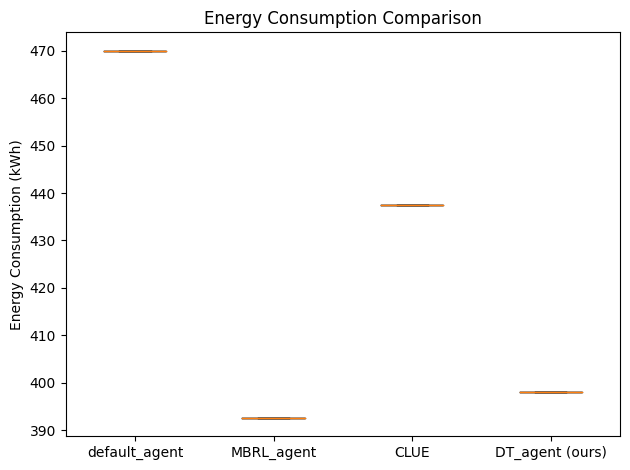

In [62]:
'''
plot energy comsumption comparison as a box chart.
if monitor_paths contains multiple paths, plot the mean and std.
'''
def plot_energy_comparison(monitor_paths):
    energy_consumption = {}
    for key in monitor_paths:
        energy_consumption[key] = []
        for path in monitor_paths[key]:
            energy_consumption[key].append(get_total_power(path, 0, 2976))
    print(energy_consumption)
    plt.boxplot(energy_consumption.values(), labels=energy_consumption.keys())
    plt.title('Energy Consumption Comparison')
    plt.ylabel('Energy Consumption (kWh)')
    plt.tight_layout()
    plt.show()

plot_energy_comparison(monitor_paths)


{'default_agent': [0.3333333333333333], 'MBRL_agent': [0.32526881720430106], 'CLUE': [0.30376344086021506], 'DT_agent (ours)': [0.302755376344086]}


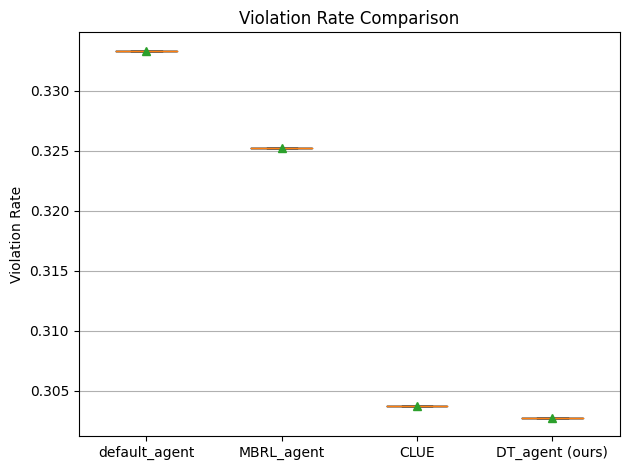

In [63]:
'''
plot violation rate comparison as a box chart.
if monitor_paths contains multiple paths, plot the mean, std, and min, max.
'''
def plot_violation_comparison(monitor_paths):
    violation_rates = {}
    for key in monitor_paths:
        violation_rates[key] = []
        for path in monitor_paths[key]:
            violation_rates[key].append(get_violation_rate(path, 20, 23.5, 0, 2976))
    print(violation_rates)
    fig, ax = plt.subplots()
    # plot the mean and std of box chart
    ax.boxplot(violation_rates.values(), labels=violation_rates.keys(), showmeans=True)
    ax.set_ylabel('Violation Rate')
    ax.set_title('Violation Rate Comparison')
    ax.yaxis.grid(True)
    fig.tight_layout()
    plt.show()

plot_violation_comparison(monitor_paths)

In [70]:
'''
compute performance gain
'''
default_vio = get_violation_rate(monitor_paths['default_agent'][0], 20, 23.5, 0, 2976)
CLUE_vio = get_violation_rate(monitor_paths['CLUE'][0], 20, 23.5, 0, 2976)
DT_vio = get_violation_rate(monitor_paths['DT_agent (ours)'][0], 20, 23.5, 0, 2976)

default_energy = get_total_power(monitor_paths['default_agent'][0], 0, 2976)
CLUE_energy = get_total_power(monitor_paths['CLUE'][0], 0, 2976)
DT_energy = get_total_power(monitor_paths['DT_agent (ours)'][0], 0, 2976)

default_energy_efficiency = default_vio / default_energy
CLUE_energy_efficiency = CLUE_vio / CLUE_energy
DT_energy_efficiency = DT_vio / DT_energy

CLUE_gain = default_vio - CLUE_vio
DT_gain = default_vio - DT_vio

CLUE_energy_gain = default_energy - CLUE_energy
DT_energy_gain = default_energy - DT_energy

print('CLUE gain: ', CLUE_gain)
print('DT gain: ', DT_gain)
print('CLUE energy gain: ', CLUE_energy_gain)
print('DT energy gain: ', DT_energy_gain)

print('DT more gain than CLUE: ', (DT_gain - CLUE_gain)/CLUE_gain)
print('DT more energy gain than CLUE: ', (DT_energy_gain - CLUE_energy_gain)/CLUE_energy_gain)


CLUE gain:  0.029569892473118253
DT gain:  0.030577956989247312
CLUE energy gain:  32.463821612799336
DT energy gain:  71.84660203956304
DT more gain than CLUE:  1.03409090909091
DT more energy gain than CLUE:  2.213128290824407


{'default_agent': [0.3333333333333333], 'MBRL_agent': [0.32526881720430106], 'CLUE': [0.30376344086021506], 'DT_agent (ours)': [0.302755376344086]}
{'default_agent': [469.9835073727395], 'MBRL_agent': [392.6427038388927], 'CLUE': [437.51968575994016], 'DT_agent (ours)': [398.13690533317646]}


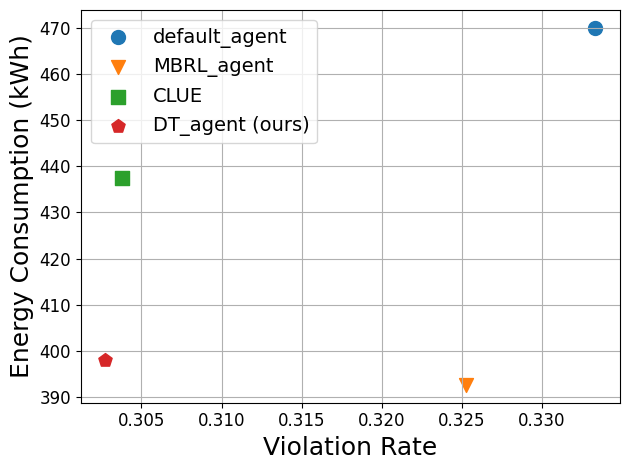

In [64]:
'''
Plot energy consumption and violation rate in one figure.
X is the violation rate, Y is the energy consumption.
Each data point represents the result from one monitor file.
Use different kind of markers to represent different agents.
'''
def plot_pareto_graph(monitor_paths):
    violation_rates = {}
    energy_consumption = {}
    for key in monitor_paths:
        violation_rates[key] = []
        energy_consumption[key] = []
        for path in monitor_paths[key]:
            violation_rates[key].append(get_violation_rate(path, 20, 23.5, 0, 2976))
            energy_consumption[key].append(get_total_power(path, 0, 2976))
    print(violation_rates)
    print(energy_consumption)
    fig, ax = plt.subplots()
    markers = ['o', 'v', 's', 'p', 'P', '*', 'h', 'H', 'D', 'd', 'X', 'x']
    for i, key in enumerate(monitor_paths):
        ax.scatter(violation_rates[key], energy_consumption[key], marker=markers[i], label=key, s=100)
    ax.legend(fontsize=14)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.set_xlabel('Violation Rate', fontsize=18)
    ax.set_ylabel('Energy Consumption (kWh)', fontsize=18)
    ax.grid(True)

    # draw an red thick arrow to indicate the direction of improvement
    # ax.annotate('', xy=(0.1, 1220), xycoords='data',
    #             xytext=(0.095, 1180), textcoords='data', 
    #             arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color='red', linewidth=2))
    # # annotate the arrow with text
    # ax.text(0.099, 1190, 'Improvement', fontsize=14, color='red')

    fig.tight_layout()
    # save to pdf
    plt.savefig('pareto_graph_tucson.pdf')
    plt.show()

plot_pareto_graph(monitor_paths)

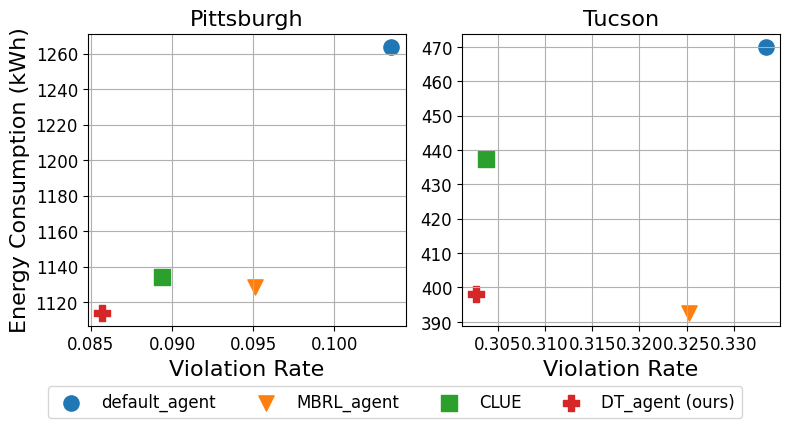

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

monitor_paths = {
    # 'random_agent': [],
    'default_agent': ['zresults/pittsburgh_default_monitor.csv'],
    'MBRL_agent': [],
    'CLUE': ['zresults/pittsburgh_CLUE_monitor.csv'],
    'DT_agent (ours)': ['zresults/pittsburgh_tree_monitor.csv'],
}
# for i in range(50):
#     monitor_paths['random_agent'].append('zresults/pittsburgh_random_{}_monitor.csv'.format(i))

# for i in range(13):
for i in range(1):
    monitor_paths['MBRL_agent'].append('zresults/pittsburgh_MBRL_{}_monitor.csv'.format(i))
violation_rates = {}
energy_consumption = {}
for key in monitor_paths:
    violation_rates[key] = []
    energy_consumption[key] = []
    for path in monitor_paths[key]:
        violation_rates[key].append(get_violation_rate(path, 20, 23.5, 0, 2976))
        energy_consumption[key].append(get_total_power(path, 0, 2976))

markers = ['o', 'v', 's', 'P', 'p', '*', 'h', 'H', 'D', 'd', 'X', 'x']
for i, key in enumerate(monitor_paths):
    ax[0].scatter(violation_rates[key], energy_consumption[key], marker=markers[i], label=key, s=120)
for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
            ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    item.set_fontsize(12)
ax[0].set_xlabel('Violation Rate', fontsize=16)
ax[0].set_ylabel('Energy Consumption (kWh)', fontsize=16)
ax[0].grid(True)

monitor_paths = {
    # 'random_agent': [],
    'default_agent': ['zresults/tucson_default_monitor.csv'],
    'MBRL_agent': ['zresults/tucson_NN_winter_1200_monitor.csv'],
    'CLUE': ['zresults/tucson_GPMCB_winter_7_0.3_monitor.csv'],
    'DT_agent (ours)': ['zresults/tucson_tree_monitor.csv'],
}
# for i in range(50):
#     monitor_paths['random_agent'].append('zresults/pittsburgh_random_{}_monitor.csv'.format(i))
violation_rates = {}
energy_consumption = {}
for key in monitor_paths:
    violation_rates[key] = []
    energy_consumption[key] = []
    for path in monitor_paths[key]:
        violation_rates[key].append(get_violation_rate(path, 20, 23.5, 0, 2976))
        energy_consumption[key].append(get_total_power(path, 0, 2976))

markers = ['o', 'v', 's', 'P', 'p', '*', 'h', 'H', 'D', 'd', 'X', 'x']
for i, key in enumerate(monitor_paths):
    ax[1].scatter(violation_rates[key], energy_consumption[key], marker=markers[i], label=key, s=120)
for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
            ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    item.set_fontsize(12)
ax[1].set_xlabel('Violation Rate', fontsize=16)
# ax[1].set_ylabel('Energy Consumption (kWh)', fontsize=18)
ax[1].grid(True)

ax[0].set_title('Pittsburgh', fontsize=16)
ax[1].set_title('Tucson', fontsize=16)


handle1, label1 = ax[0].get_legend_handles_labels()

lgd = fig.legend(handle1, label1, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=12)

# tight layout
plt.tight_layout()

fig.savefig('two_paretos.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

DT more gain than CLUE:  -4.421598876287445


In [67]:
'''
overheads
'''

overhead_paths = {
    # 'random_agent': [],
    'default_agent': ['zresults/pittsburgh_default_overhead.csv'],
    'MBRL_agent': ['zresults/pittsburgh_MBRL_0_overhead.csv'],
    'CLUE': ['zresults/pittsburgh_CLUE_overhead.csv'],
    'DT_agent (ours)': ['zresults/pittsburgh_tree_overhead.csv'],
}

def get_overhead(monitor_path):
    df = pd.read_csv(monitor_path)
    avg = df['time_overhead'].mean()
    std = df['time_overhead'].std()
    mode = df['time_overhead'].mode()[0]
    return avg, std, mode

overheads = {}
for key in overhead_paths:
    overheads[key] = []
    for path in overhead_paths[key]:
        overheads[key].append(get_overhead(path))

print(overheads)

{'default_agent': [(0.0, 0.0, 0)], 'MBRL_agent': [(212.87298387096774, 266.89782767212984, 0)], 'CLUE': [(326.3081317204301, 102.30557037039029, 303)], 'DT_agent (ours)': [(0.18884408602150538, 0.4422515439426243, 0)]}
